<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/rayTracingAndStops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray Tracing for Spherical Surfaces

## David Brady
## University of Arizona


### Python Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
import sympy
from google.colab import files
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams.update({'font.size': 22})
mpl.rcParams['lines.linewidth'] = 1.5
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] =  cycler(color =['#0000ff'])

## Solving for ray intersetions and refraction angles

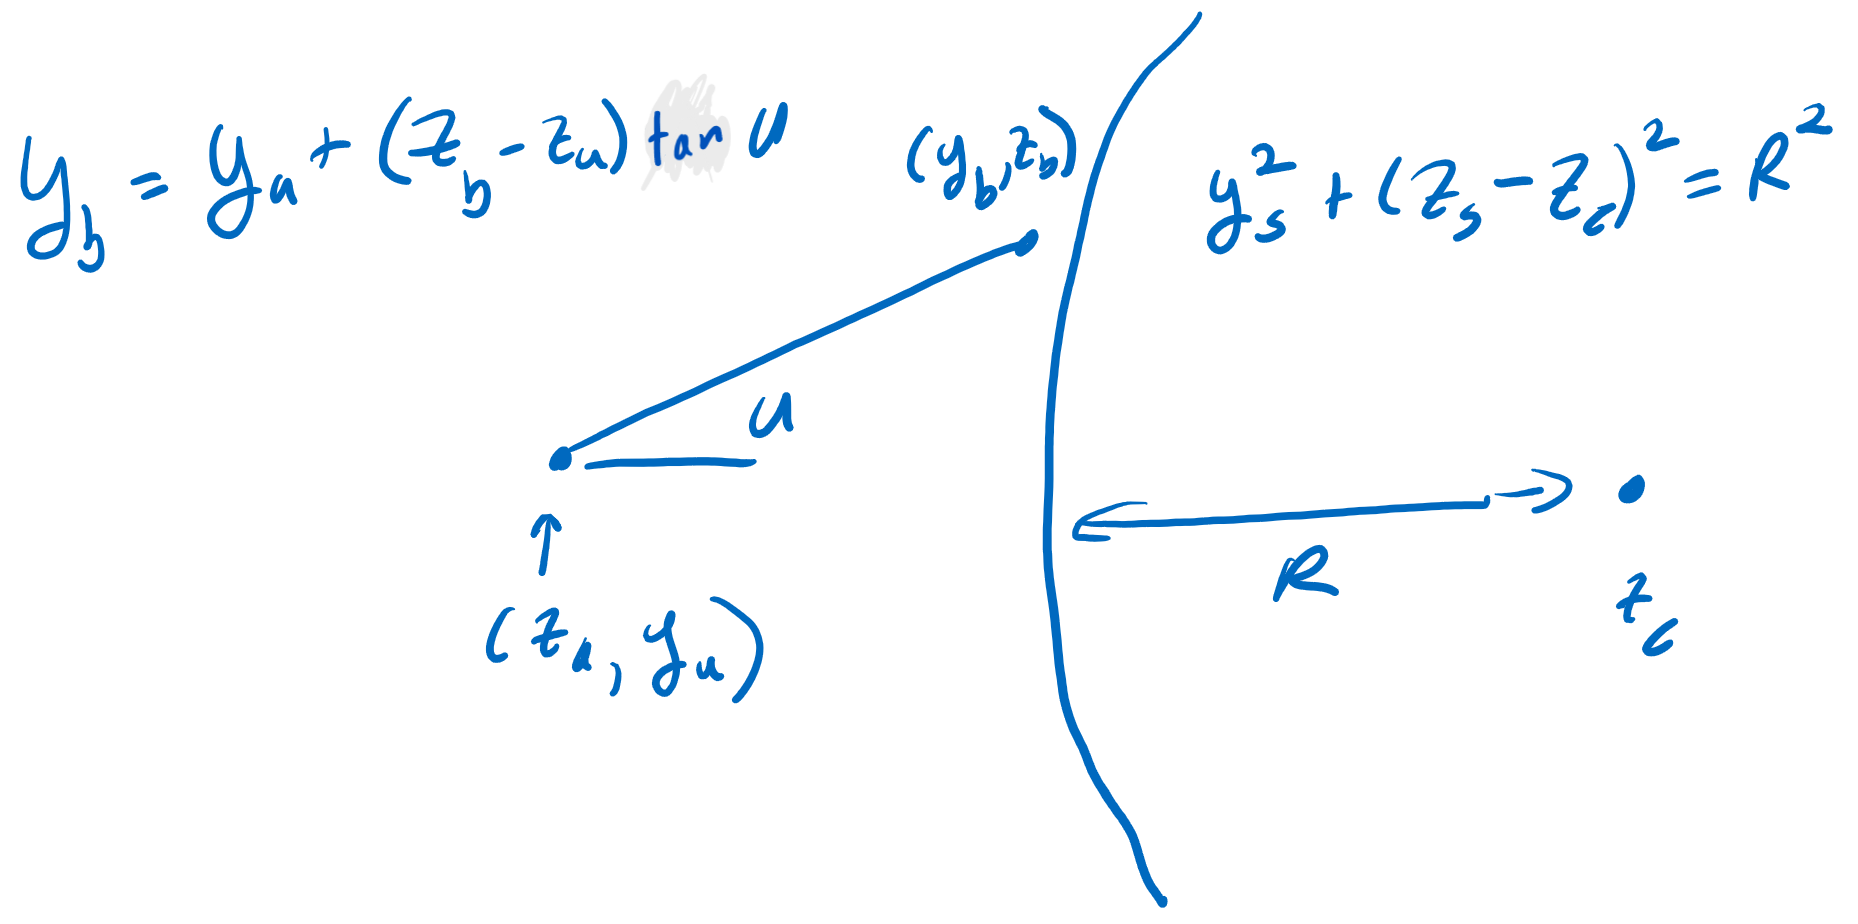

As illustrated in the figure above,  we consider ray tracing in the meridional plane with spherical surfaces. We define position in the meridional plane by ray height y and ray longitude z. The ray also has an angle U, so the ray height evolves according to 
$$y_b=y_a+(z_b-z_a) \tan (U)$$

A surface is defined by a radius of curvature $R$ and a center of curvature $z_c$ Points on the surface are described by the equation
$$y_s^2+(z_s-z_c)^2=R^2$$

The incident ray intersects the surface when $(y_b,z_b)=(y_s,z_s)$. For $R>0$, we select solutions $z_s<z_o$, for $R<0$ we select solutions $z_s<z_o$.



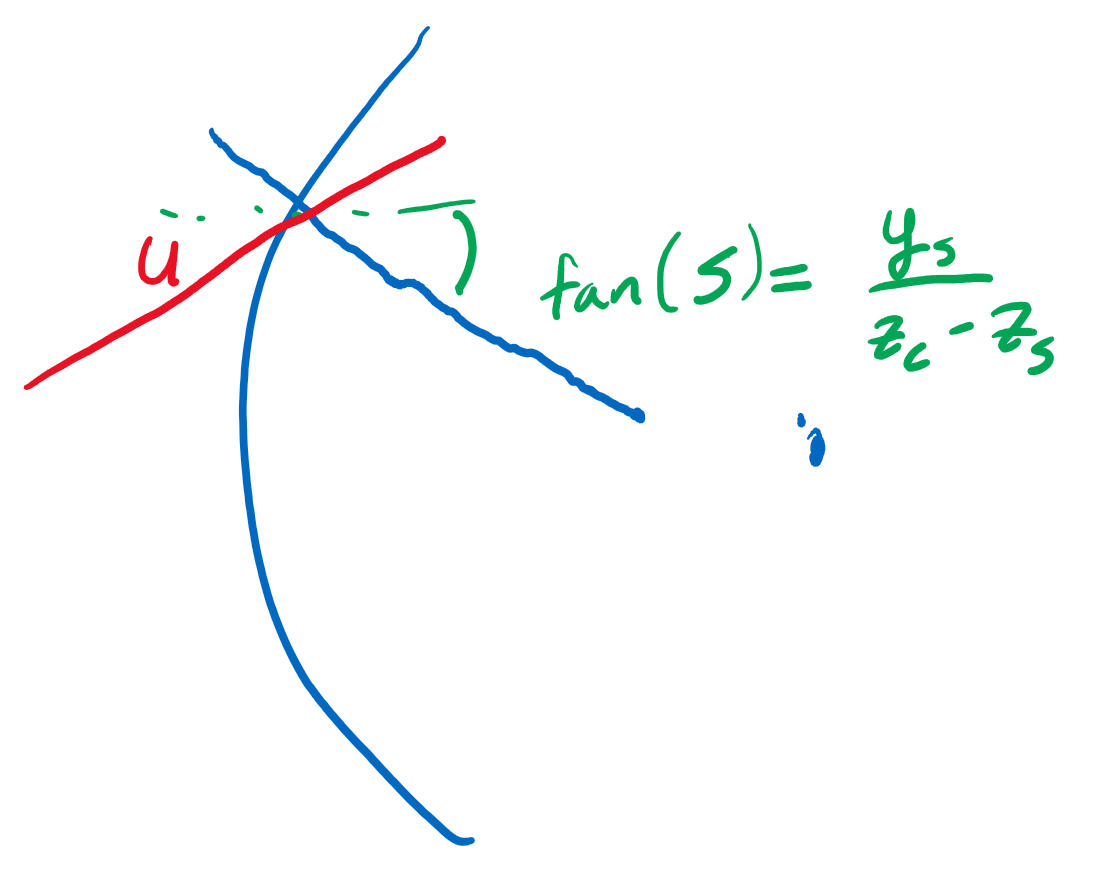

As illustrated above,  the angle the surface normal makes to the horizonatal axis is $S =\tan^{-1}(\frac{y_s}{z_s-z_o})$. Since the incident ray is at angle $U$ relative to the optical axis, Snell's law at the surface is
$$n_2\sin (U'+S)=n_1 \sin (S+U)$$
Solving for $U'$ allows us to propagate the ray to the next surface.


In [3]:
def p(ya,za,u,zc,R):
  # this function returns the intersection of the ray 
  # starting at point ya, za with slope u with the circle 
  # centered at y=0,z=zc with radius of curvature R
  yy, zz = sympy.symbols('yy zz')
  pSol=sympy.solve([yy-ya-(zz-za)*sympy.tan(u),yy**2+(zz-zc)**2-R**2], [yy, zz])
  if R>0:
    if pSol[0][1]<zc:
      p=pSol[0]
    else:
       p=pSol[1]
  else:
    if pSol[0][1]>zc:
       p=pSol[0]
    else:
      p=pSol[1]
  return p
def up(y,z,u,zc,n1,n2):
  # this function returns the angle relative to the optical 
  # axis of a ray striking a spherical surface centered at zx at point y,z 
  # incident index n1 and refracted index n2
  S=np.arctan(float(y/(zc-z)))
  up=np.arcsin(n1*np.sin(u+S)/n2)-S
  return up


## Ray tracing vs aperture size and fov in a thick lens

We consider a lens with R1=10 mm and R2=-10 mm, with index n=1.7 and thickness 1.5 mm

In [4]:
R1=10 #mm
v1=2
R2=-10 ##
v2=3.5
zc1=v1+R1
zc2=v2+R2
n1=1
n2=1.7
n3=1


We can analyze this lens using Gaussian analysis to find

In [5]:
phi1=(n2-n1)/R1
phi2=(n3-n2)/R2
tau=(v2-v1)/n2
phi=phi1+phi2-phi1*phi2*tau
f=1/phi
print("According to gaussian analysis, the focal length is ", f," mm")
# location of the rear focal plane from the right vertex
dp=-tau*phi1/phi
print("the location of the rear principal plane is ", v2+dp," mm")
print("the back focal point is ", v2+dp+f," mm")

According to gaussian analysis, the focal length is  7.3704747452850645  mm
the location of the rear principal plane is  3.044764795144158  mm
the back focal point is  10.415239540429223  mm


we can trace a set of rays from infinite conjugate through this system to find the quality of the focus. 

In [ ]:
numberOfRays=7
rP=np.zeros((numberOfRays,4,2))
apertureHeight=1.5
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for rays in range(numberOfRays):
  ya= yV[rays]
  za=0
  u=0
  # intersection with the first surface
  y1, z1= p(ya,za,u,zc1,R1)
  # slope after first surface
  up1=up(y1,z1,u,zc1,n1,n2)
  y2, z2= p(y1,z1,up1,zc2,R2)
  #slope after second surface
  up2=up(y2,z2,up1,zc2,n2,n3)
  # ray position at the focal plane
  zf=v2+dp+f
  yf=y2+(zf-z2)*np.tan(up2)
  rP[rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

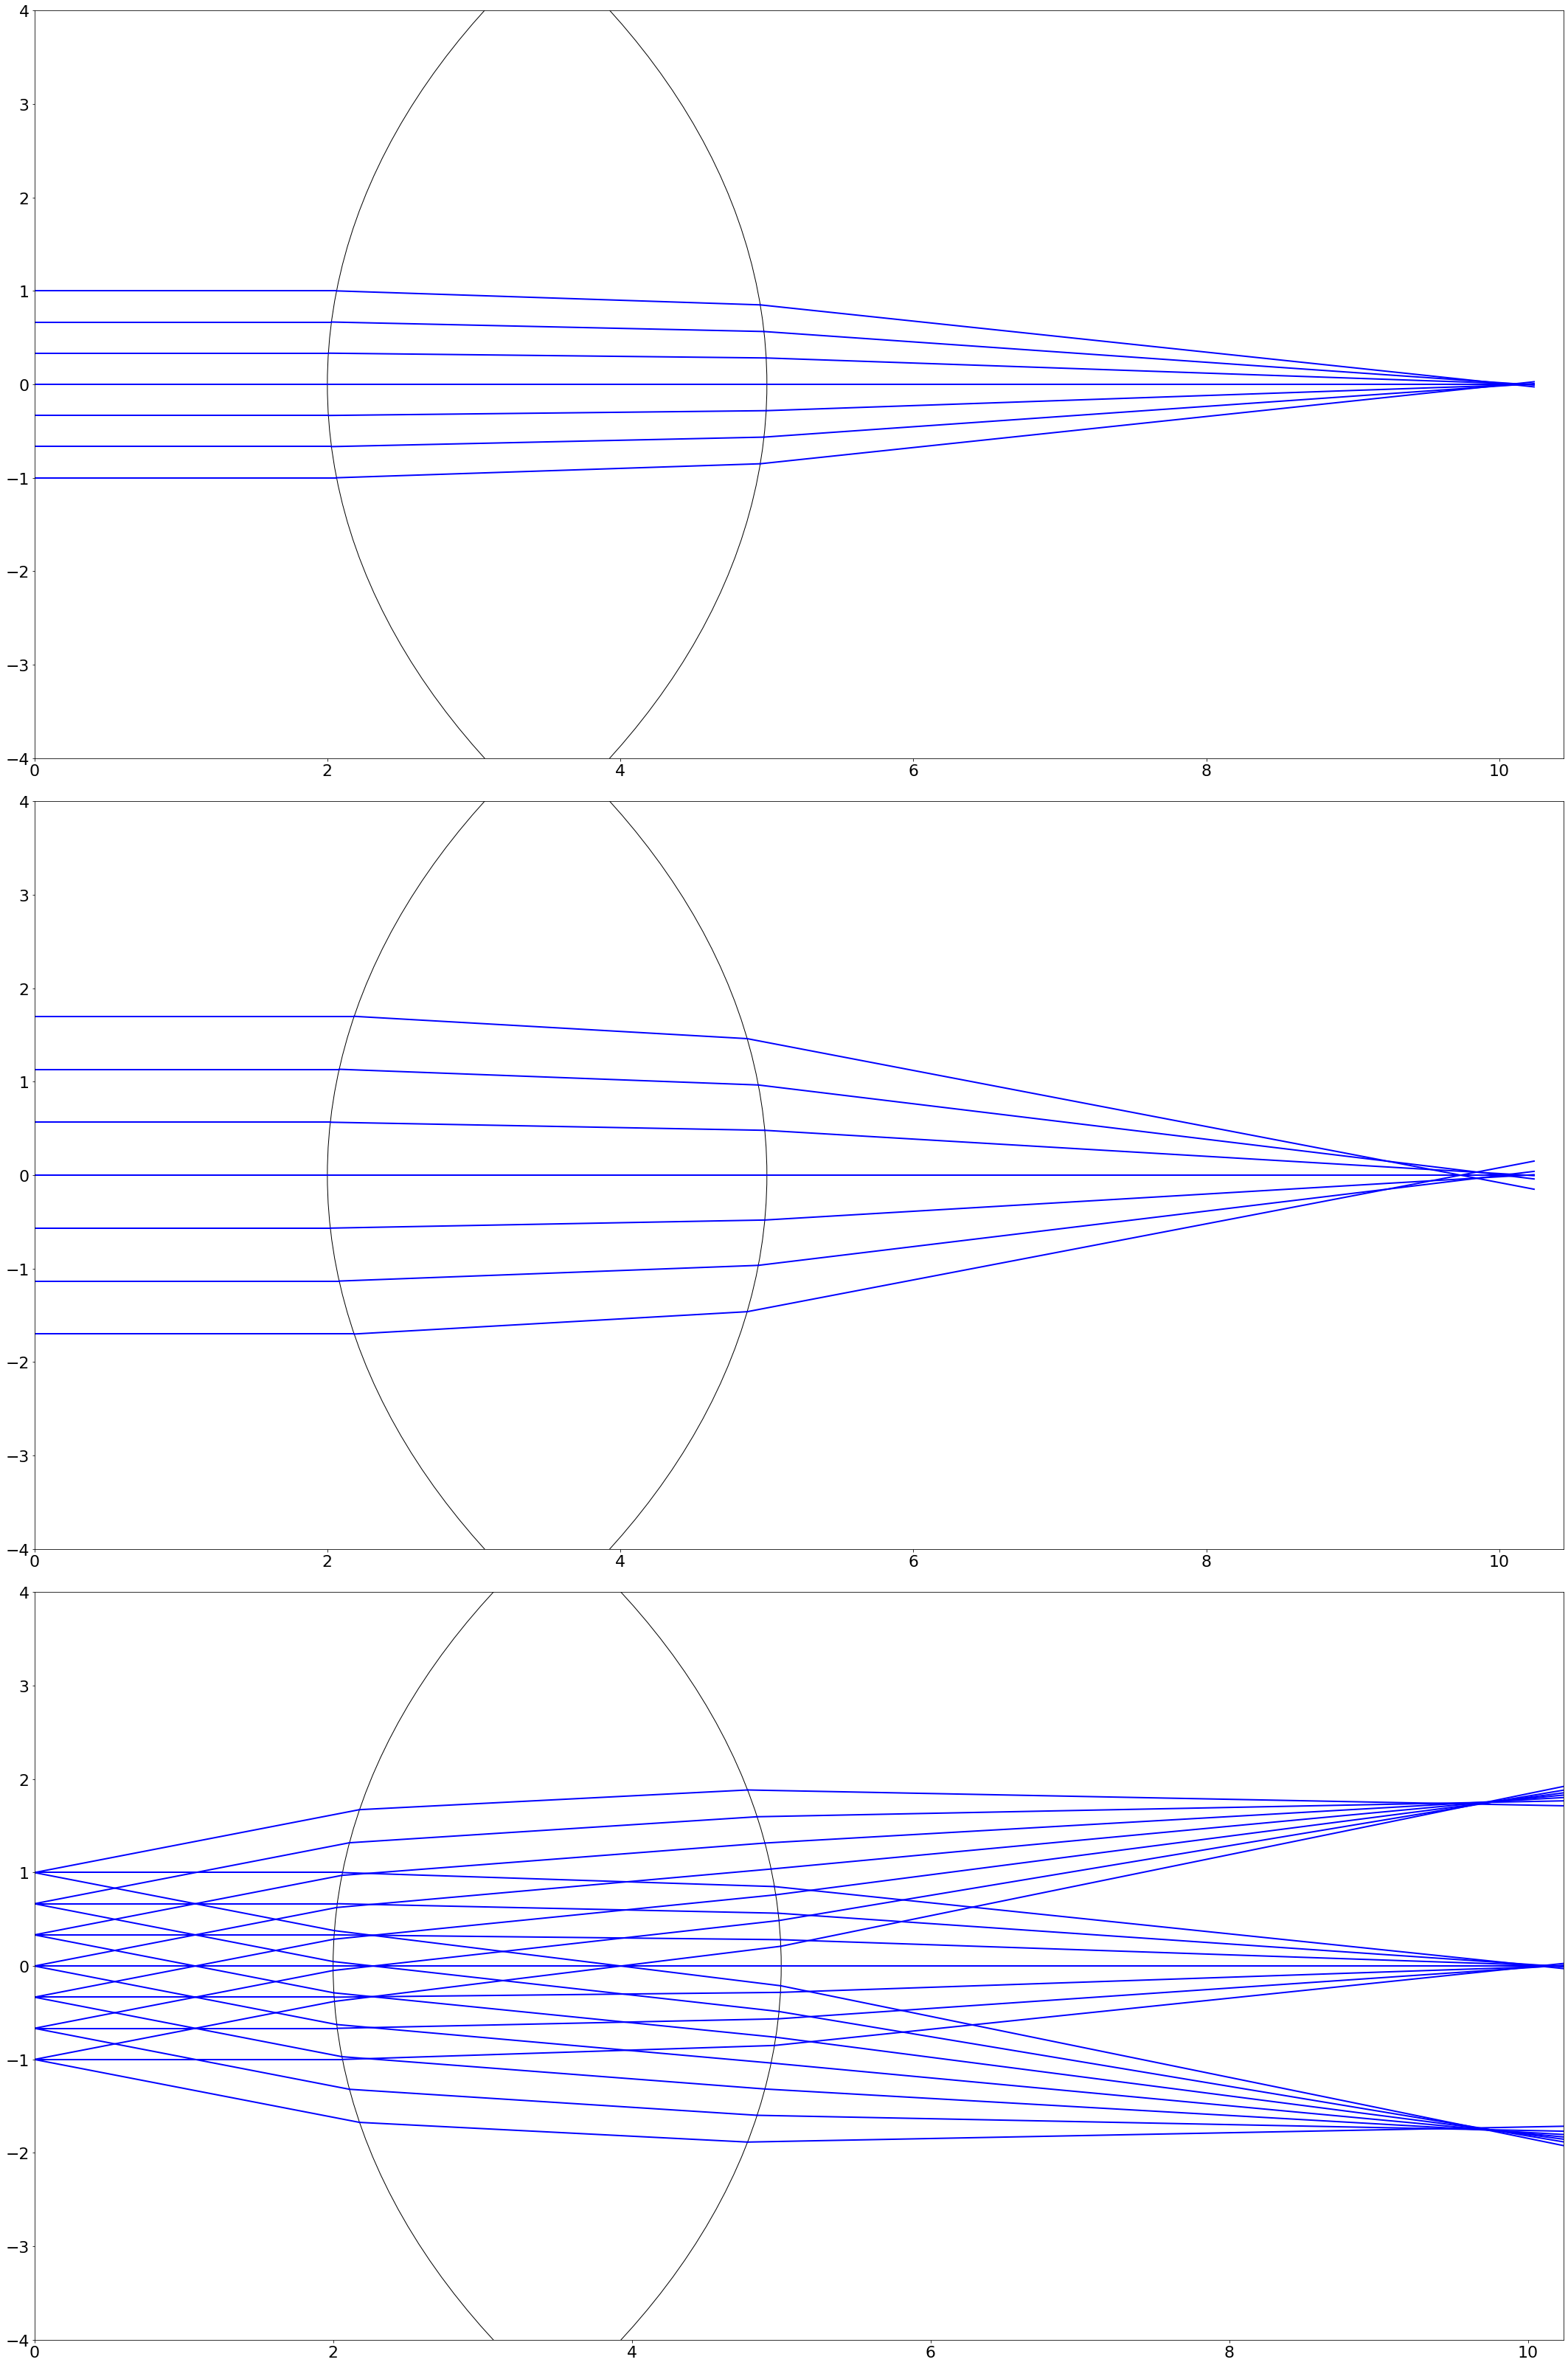

In [ ]:
# find rays
numberOfRays=7
rP=np.zeros((numberOfRays,4,2))
apertureHeight=1
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for rays in range(numberOfRays):
  ya= yV[rays]
  za=0
  u=0
  # intersection with the first surface
  y1, z1= p(ya,za,u,zc1,R1)
  # slope after first surface
  up1=up(y1,z1,u,zc1,n1,n2)
  y2, z2= p(y1,z1,up1,zc2,R2)
  #slope after second surface
  up2=up(y2,z2,up1,zc2,n2,n3)
  # ray position at the focal plane
  zf=v2+dp+f
  yf=y2+(zf-z2)*np.tan(up2)
  rP[rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))
# plot rays
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
#plt.axis('equal')
plt.subplot(3,1,1)
plt.ylim([-4,4])
plt.xlim([0,v2+dp+f+.2])
for pip in range(numberOfRays):
  plt.plot([rP[pip,0,0],rP[pip,1,0]],[rP[pip,0,1],rP[pip,1,1]],[rP[pip,1,0],rP[pip,2,0]],[rP[pip,1,1],rP[pip,2,1]],[rP[pip,2,0],rP[pip,3,0]],[rP[pip,2,1],rP[pip,3,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)

# find rays, larger initial aperture size
numberOfRays=7
rP=np.zeros((numberOfRays,4,2))
apertureHeight=1.7
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for rays in range(numberOfRays):
  ya= yV[rays]
  za=0
  u=0
  # intersection with the first surface
  y1, z1= p(ya,za,u,zc1,R1)
  # slope after first surface
  up1=up(y1,z1,u,zc1,n1,n2)
  y2, z2= p(y1,z1,up1,zc2,R2)
  #slope after second surface
  up2=up(y2,z2,up1,zc2,n2,n3)
  # ray position at the focal plane
  zf=v2+dp+f
  yf=y2+(zf-z2)*np.tan(up2)
  rP[rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))
# plot rays
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
#plt.axis('equal')
plt.subplot(3,1,2)
plt.ylim([-4,4])
plt.xlim([0,v2+dp+f+.2])
for pip in range(numberOfRays):
  plt.plot([rP[pip,0,0],rP[pip,1,0]],[rP[pip,0,1],rP[pip,1,1]],[rP[pip,1,0],rP[pip,2,0]],[rP[pip,1,1],rP[pip,2,1]],[rP[pip,2,0],rP[pip,3,0]],[rP[pip,2,1],rP[pip,3,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)


# find rays, off axis rays
numberOfRays=7
rPa=np.zeros((3,numberOfRays,4,2))
apertureHeight=1
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for ua in [-1,0,1]:
  for rays in range(numberOfRays):
    ya= yV[rays]
    za=0
    u=.3*ua
    # intersection with the first surface
    y1, z1= p(ya,za,u,zc1,R1)
    # slope after first surface
    up1=up(y1,z1,u,zc1,n1,n2)
    y2, z2= p(y1,z1,up1,zc2,R2)
    #slope after second surface
    up2=up(y2,z2,up1,zc2,n2,n3)
    # ray position at the focal plane
    zf=v2+dp+f
    yf=y2+(zf-z2)*np.tan(up2)
    rPa[ua,rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))
# plot rays
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
#plt.axis('equal')
plt.subplot(3,1,3)
plt.ylim([-4,4])
plt.xlim([0,v2+dp+f])
for pip in range(numberOfRays):
  plt.plot([rPa[0,pip,0,0],rPa[0,pip,1,0]],[rPa[0,pip,0,1],rPa[0,pip,1,1]],[rPa[0,pip,1,0],rPa[0,pip,2,0]],[rPa[0,pip,1,1],rPa[0,pip,2,1]],[rPa[0,pip,2,0],rPa[0,pip,3,0]],[rPa[0,pip,2,1],rPa[0,pip,3,1]])
  plt.plot([rPa[1,pip,0,0],rPa[1,pip,1,0]],[rPa[1,pip,0,1],rPa[1,pip,1,1]],[rPa[1,pip,1,0],rPa[1,pip,2,0]],[rPa[1,pip,1,1],rPa[1,pip,2,1]],[rPa[1,pip,2,0],rPa[1,pip,3,0]],[rPa[1,pip,2,1],rPa[1,pip,3,1]])
  plt.plot([rPa[2,pip,0,0],rPa[2,pip,1,0]],[rPa[2,pip,0,1],rPa[2,pip,1,1]],[rPa[2,pip,1,0],rPa[2,pip,2,0]],[rPa[2,pip,1,1],rPa[2,pip,2,1]],[rPa[2,pip,2,0],rPa[2,pip,3,0]],[rPa[2,pip,2,1],rPa[2,pip,3,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)
plt.savefig("rayTrace.pdf")
files.download("rayTrace.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

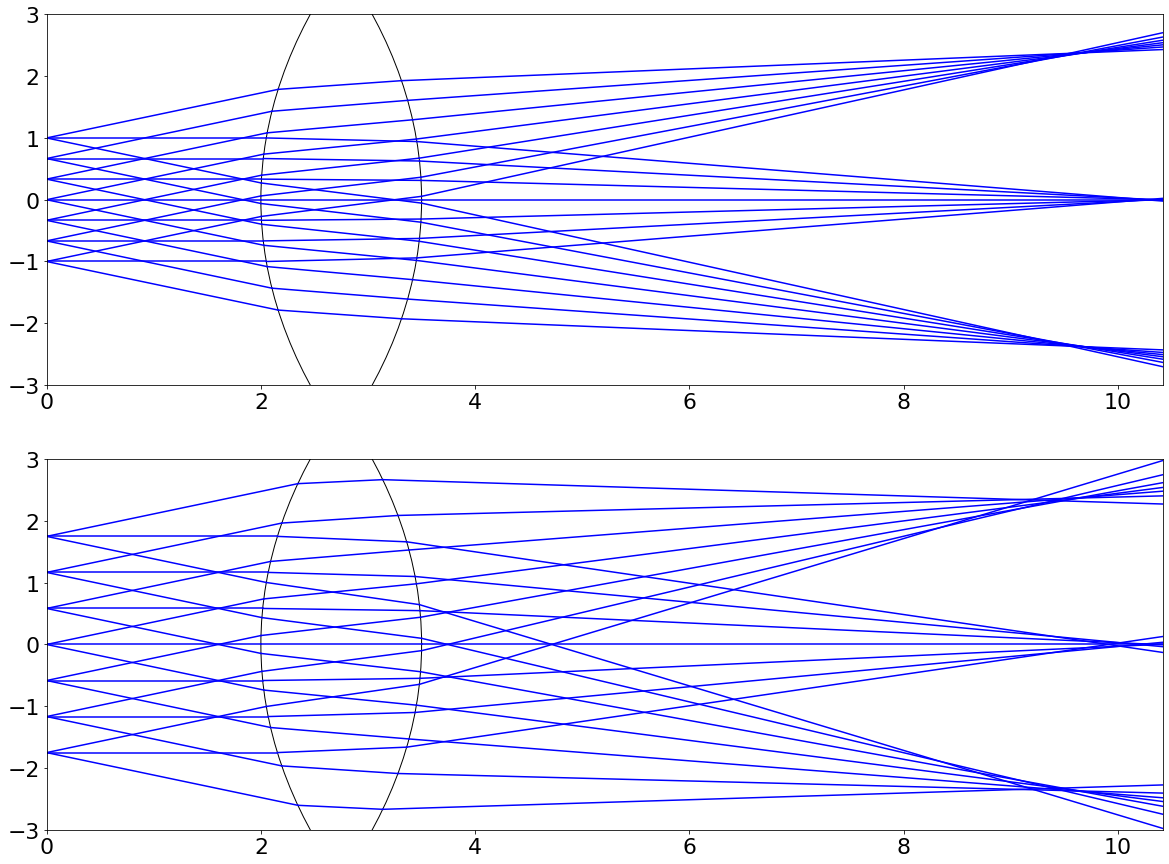

In [ ]:


# find rays, off axis rays
numberOfRays=7
rPa=np.zeros((3,numberOfRays,4,2))
apertureHeight=1
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for ua in [-1,0,1]:
  for rays in range(numberOfRays):
    ya= yV[rays]
    za=0
    u=(20*np.pi/180)*ua
    # intersection with the first surface
    y1, z1= p(ya,za,u,zc1,R1)
    # slope after first surface
    up1=up(y1,z1,u,zc1,n1,n2)
    y2, z2= p(y1,z1,up1,zc2,R2)
    #slope after second surface
    up2=up(y2,z2,up1,zc2,n2,n3)
    # ray position at the focal plane
    zf=v2+dp+f
    yf=y2+(zf-z2)*np.tan(up2)
    rPa[ua,rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))
# plot rays
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
#plt.axis('equal')
plt.subplot(2,1,1)
plt.ylim([-3,3])
plt.xlim([0,v2+dp+f])
for pip in range(numberOfRays):
  plt.plot([rPa[0,pip,0,0],rPa[0,pip,1,0]],[rPa[0,pip,0,1],rPa[0,pip,1,1]],[rPa[0,pip,1,0],rPa[0,pip,2,0]],[rPa[0,pip,1,1],rPa[0,pip,2,1]],[rPa[0,pip,2,0],rPa[0,pip,3,0]],[rPa[0,pip,2,1],rPa[0,pip,3,1]])
  plt.plot([rPa[1,pip,0,0],rPa[1,pip,1,0]],[rPa[1,pip,0,1],rPa[1,pip,1,1]],[rPa[1,pip,1,0],rPa[1,pip,2,0]],[rPa[1,pip,1,1],rPa[1,pip,2,1]],[rPa[1,pip,2,0],rPa[1,pip,3,0]],[rPa[1,pip,2,1],rPa[1,pip,3,1]])
  plt.plot([rPa[2,pip,0,0],rPa[2,pip,1,0]],[rPa[2,pip,0,1],rPa[2,pip,1,1]],[rPa[2,pip,1,0],rPa[2,pip,2,0]],[rPa[2,pip,1,1],rPa[2,pip,2,1]],[rPa[2,pip,2,0],rPa[2,pip,3,0]],[rPa[2,pip,2,1],rPa[2,pip,3,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)


# find rays, off axis rays
numberOfRays=7
rPa=np.zeros((3,numberOfRays,4,2))
apertureHeight=1.75
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for ua in [-1,0,1]:
  for rays in range(numberOfRays):
    ya= yV[rays]
    za=0
    u=(20*np.pi/180)*ua
    # intersection with the first surface
    y1, z1= p(ya,za,u,zc1,R1)
    # slope after first surface
    up1=up(y1,z1,u,zc1,n1,n2)
    y2, z2= p(y1,z1,up1,zc2,R2)
    #slope after second surface
    up2=up(y2,z2,up1,zc2,n2,n3)
    # ray position at the focal plane
    zf=v2+dp+f
    yf=y2+(zf-z2)*np.tan(up2)
    rPa[ua,rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))
# plot rays
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
#plt.axis('equal')
plt.subplot(2,1,2)
plt.ylim([-3,3])
plt.xlim([0,v2+dp+f])
for pip in range(numberOfRays):
  plt.plot([rPa[0,pip,0,0],rPa[0,pip,1,0]],[rPa[0,pip,0,1],rPa[0,pip,1,1]],[rPa[0,pip,1,0],rPa[0,pip,2,0]],[rPa[0,pip,1,1],rPa[0,pip,2,1]],[rPa[0,pip,2,0],rPa[0,pip,3,0]],[rPa[0,pip,2,1],rPa[0,pip,3,1]])
  plt.plot([rPa[1,pip,0,0],rPa[1,pip,1,0]],[rPa[1,pip,0,1],rPa[1,pip,1,1]],[rPa[1,pip,1,0],rPa[1,pip,2,0]],[rPa[1,pip,1,1],rPa[1,pip,2,1]],[rPa[1,pip,2,0],rPa[1,pip,3,0]],[rPa[1,pip,2,1],rPa[1,pip,3,1]])
  plt.plot([rPa[2,pip,0,0],rPa[2,pip,1,0]],[rPa[2,pip,0,1],rPa[2,pip,1,1]],[rPa[2,pip,1,0],rPa[2,pip,2,0]],[rPa[2,pip,1,1],rPa[2,pip,2,1]],[rPa[2,pip,2,0],rPa[2,pip,3,0]],[rPa[2,pip,2,1],rPa[2,pip,3,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)
plt.savefig("rayTrace.pdf")
files.download("rayTrace.pdf")

###Focal position vs. Marginal ray height

Text(0, 0.5, 'height at focal plane')

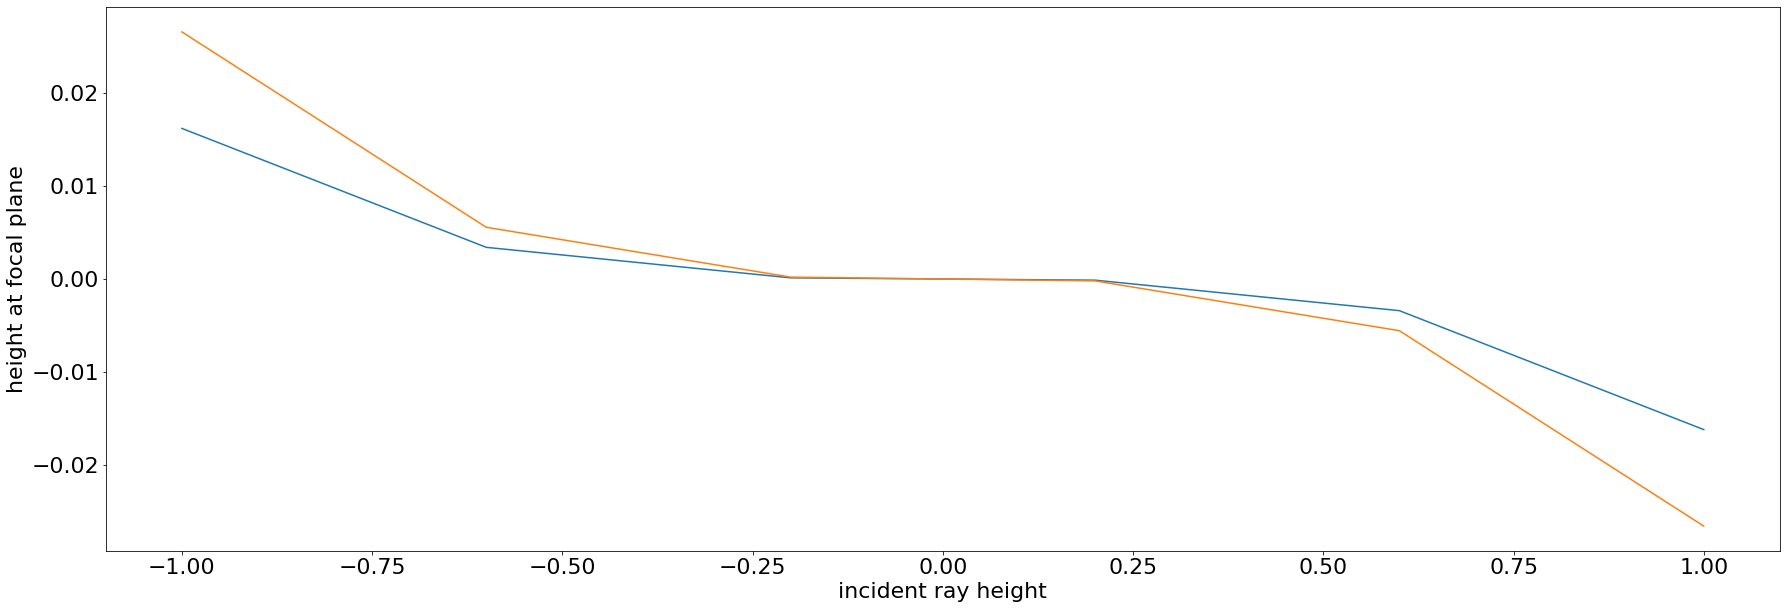

In [ ]:
plt.plot(rP[0:6,0,1],rP[0:6,3,1],rP[0:6,0,1],rr)
plt.xlabel("incident ray height")
plt.ylabel("height at focal plane")

## Adding a field corrector

In [85]:
R1=14 #mm
v1=2
R2=-14 ##
v2=3
zc1=v1+R1
zc2=v2+R2
n1=1
n2=1.7
n3=1
R3=15
v3=6
zc3=v3+R3
n4=1.5
R4=10000
v4=7
zc4=v4+R4
n5=1

the effective focal length is 7.98905666938806


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

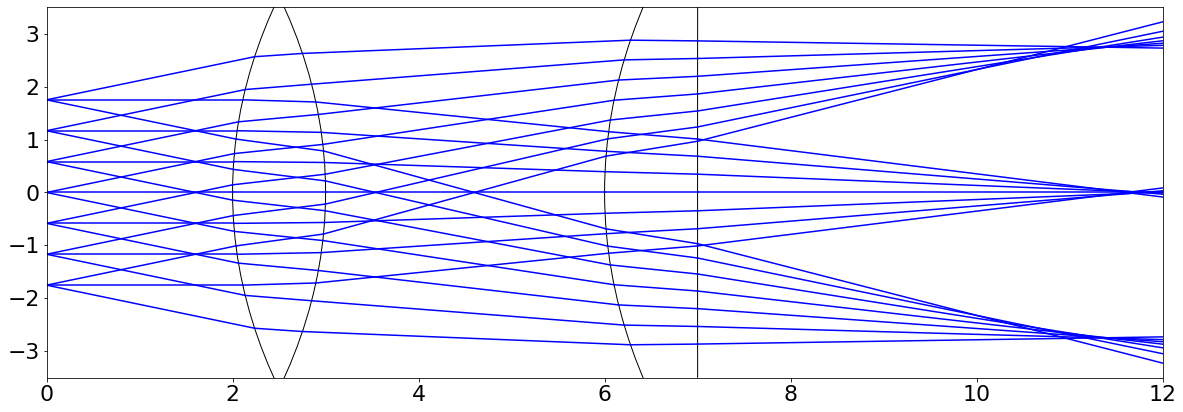

In [86]:
# find rays, off axis rays
numberOfRays=7
rPa=np.zeros((3,numberOfRays,6,2))
apertureHeight=1.75
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for ua in [-1,0,1]:
  for rays in range(numberOfRays):
    ya= yV[rays]
    za=0
    u=(20*np.pi/180)*ua
    # intersection with the first surface
    y1, z1= p(ya,za,u,zc1,R1)
    # slope after first surface
    up1=up(y1,z1,u,zc1,n1,n2)
    y2, z2= p(y1,z1,up1,zc2,R2)
    #slope after second surface
    up2=up(y2,z2,up1,zc2,n2,n3)
    # ray position at the third surface
    y3, z3= p(y2,z2,up2,zc3,R3)
    #s slope after third surface
    up3=up(y3,z3,up2,zc3,n3,n4)
    # ray position at the fourth surface
    y4, z4= p(y3,z3,up3,zc4,R4)
    # slope after fourth surface
    up4=up(y4,z4,up3,zc4,n4,n5)
    # ray position at the focal plane
    zf=v4+5
    yf=y4+(zf-z4)*np.tan(up4)
    if ua==0:
      if rays== 0:
        efl=-y1/np.tan(up4)
        print("the effective focal length is", -y1/np.tan(up4))
    rPa[ua,rays,:,:]=((za,ya),(z1,y1),(z2,y2),(z3,y3),(z4,y4),(zf,yf))
# plot rays
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
arc3 = patches.Arc((zc3,0),2*R3,2*R3,angle=0,theta1=90,theta2=270)
arc4 = patches.Arc((zc4,0),2*R4,2*R4,angle=0,theta1=90,theta2=270)
#plt.axis('equal')
plt.subplot(2,1,1)
plt.ylim([-3.5,3.5])
plt.xlim([0,v4+5])
for pip in range(numberOfRays):
  plt.plot([rPa[0,pip,0,0],rPa[0,pip,1,0]],[rPa[0,pip,0,1],rPa[0,pip,1,1]],[rPa[0,pip,1,0],rPa[0,pip,2,0]],[rPa[0,pip,1,1],rPa[0,pip,2,1]],[rPa[0,pip,2,0],rPa[0,pip,3,0]],[rPa[0,pip,2,1],rPa[0,pip,3,1]],[rPa[0,pip,3,0],rPa[0,pip,4,0]],[rPa[0,pip,3,1],rPa[0,pip,4,1]],[rPa[0,pip,4,0],rPa[0,pip,5,0]],[rPa[0,pip,4,1],rPa[0,pip,5,1]])
  plt.plot([rPa[1,pip,0,0],rPa[1,pip,1,0]],[rPa[1,pip,0,1],rPa[1,pip,1,1]],[rPa[1,pip,1,0],rPa[1,pip,2,0]],[rPa[1,pip,1,1],rPa[1,pip,2,1]],[rPa[1,pip,2,0],rPa[1,pip,3,0]],[rPa[1,pip,2,1],rPa[1,pip,3,1]],[rPa[1,pip,3,0],rPa[1,pip,4,0]],[rPa[1,pip,3,1],rPa[1,pip,4,1]],[rPa[1,pip,4,0],rPa[1,pip,5,0]],[rPa[1,pip,4,1],rPa[1,pip,5,1]])
  plt.plot([rPa[2,pip,0,0],rPa[2,pip,1,0]],[rPa[2,pip,0,1],rPa[2,pip,1,1]],[rPa[2,pip,1,0],rPa[2,pip,2,0]],[rPa[2,pip,1,1],rPa[2,pip,2,1]],[rPa[2,pip,2,0],rPa[2,pip,3,0]],[rPa[2,pip,2,1],rPa[2,pip,3,1]],[rPa[2,pip,3,0],rPa[2,pip,4,0]],[rPa[2,pip,3,1],rPa[2,pip,4,1]],[rPa[2,pip,4,0],rPa[2,pip,5,0]],[rPa[2,pip,4,1],rPa[2,pip,5,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)
plt.gca().add_patch(arc3)
plt.gca().add_patch(arc4)
plt.savefig("rayTraceSplit.pdf")
files.download("rayTraceSplit.pdf")

# Ball lens

A ball lens is a sphere of glass. See this [link](https://www.edmundoptics.com/knowledge-center/application-notes/optics/understanding-ball-lenses/) for a discussion of the lens properties. 

Use ray tracing to find the focus position for a ball lens of radius 3 mm and index 1.6 in air. Plot the ray paths for 7 rays incident parallel to the optical axis with ray heights evenly space between -1.5 and 1.5 mm. 

In [ ]:
R1=3 #mm
v1=0
R2=-3 ##
v2=6 
zc1=v1+R1
zc2=v2+R2
n1=1
n2=1.7
n3=1


In [ ]:
#ball lens efl
efl=2*n2*R1/(4*(n2-1))
print("The effective focal length is ", efl)
print("The back focal distance is ", efl-R1)


The effective focal length is  3.642857142857143
The back focal distance is  0.6428571428571428


In [ ]:
ya=.1  # mm
za=0
u=0
# intersection with the first surface
y1, z1= p(ya,za,u,zc1,R1)
# slope after first surface
up1=up(y1,z1,u,zc1,n1,n2)
print('the first refracted angle is ', up1)
#intersection with the second surface
y2, z2= p(y1,z1,up1,zc2,R2)
#slope after second surface
up2=up(y2,z2,up1,zc2,n2,n3)
print('the second refracted angle is ', up2)
zf=z2-y2/np.tan(up2)
print('the focal position is', zf)
print('the effective focal length is ', -ya/np.tan(up2))

the first refracted angle is  -0.013730409476842637
the second refracted angle is  -0.02746081895368533
the focal position is 6.64200971394157
the effective focal length is  3.6406365867035744


In [ ]:
zf

6.64200971394157

In [ ]:
numberOfRays=6
rP=np.zeros((numberOfRays,4,2))
apertureHeight=1 
yV=np.linspace(-apertureHeight,apertureHeight,numberOfRays)
for rays in range(numberOfRays):
  ya= yV[rays]
  za=0
  u=0
  # intersection with the first surface
  y1, z1= p(ya,za,u,zc1,R1)
  # slope after first surface
  up1=up(y1,z1,u,zc1,n1,n2)
  y2, z2= p(y1,z1,up1,zc2,R2)
  #slope after second surface
  up2=up(y2,z2,up1,zc2,n2,n3)
  # ray position at the focal plane
  yf=y2+(zf-z2)*np.tan(up2)
  rP[rays,:,:]=((za,ya),(z1,y1),(z2,y2),(zf,yf))


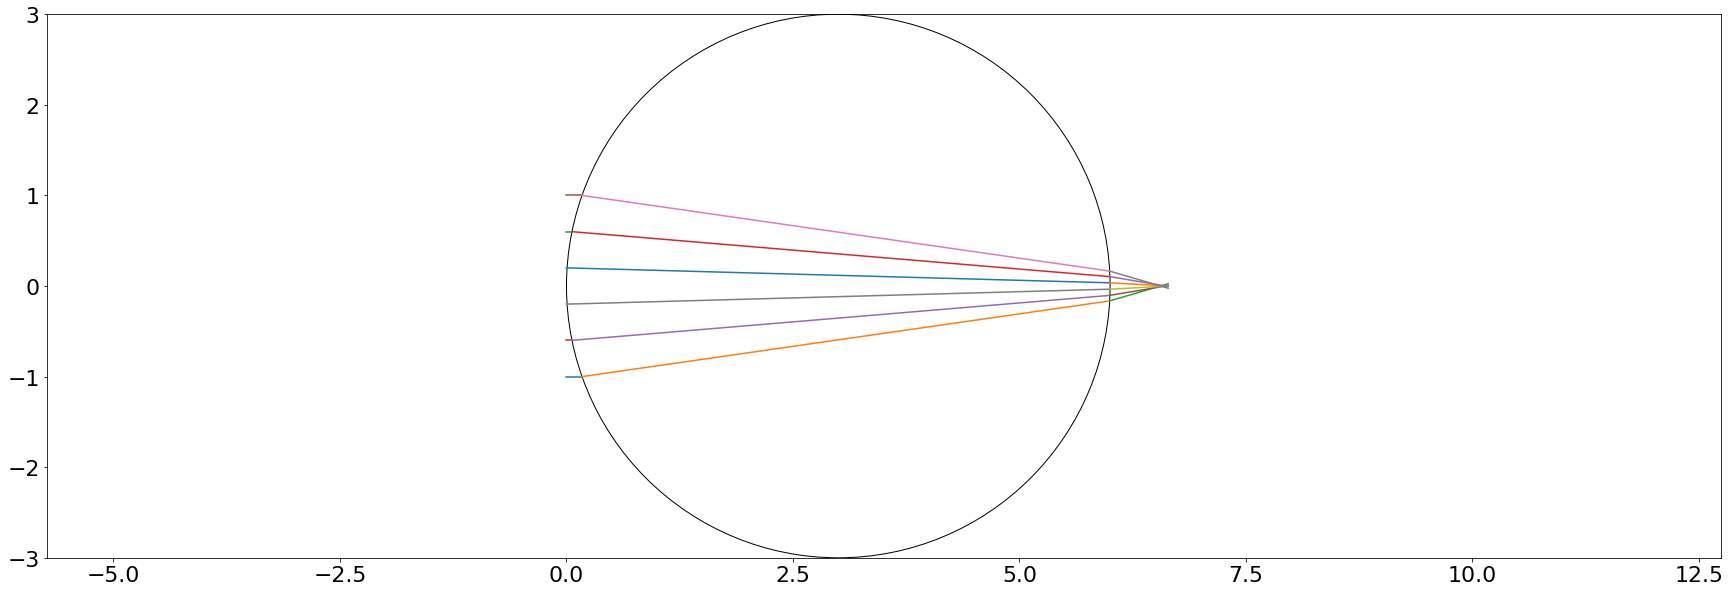

In [ ]:
arc1 = patches.Arc((zc1,0),2*R1,2*R1,angle=0,theta1=90,theta2=270)
arc2 = patches.Arc((zc2,0),2*R2,2*R2,angle=0,theta1=90,theta2=270)
plt.axis('equal')
plt.ylim([-3,3])
plt.xlim([0,7])
for pip in range(6):
  plt.plot([rP[pip,0,0],rP[pip,1,0]],[rP[pip,0,1],rP[pip,1,1]],[rP[pip,1,0],rP[pip,2,0]],[rP[pip,1,1],rP[pip,2,1]],[rP[pip,2,0],rP[pip,3,0]],[rP[pip,2,1],rP[pip,3,1]])
plt.gca().add_patch(arc1)
plt.gca().add_patch(arc2)
plt.show()

Text(0, 0.5, 'height at focal plane')

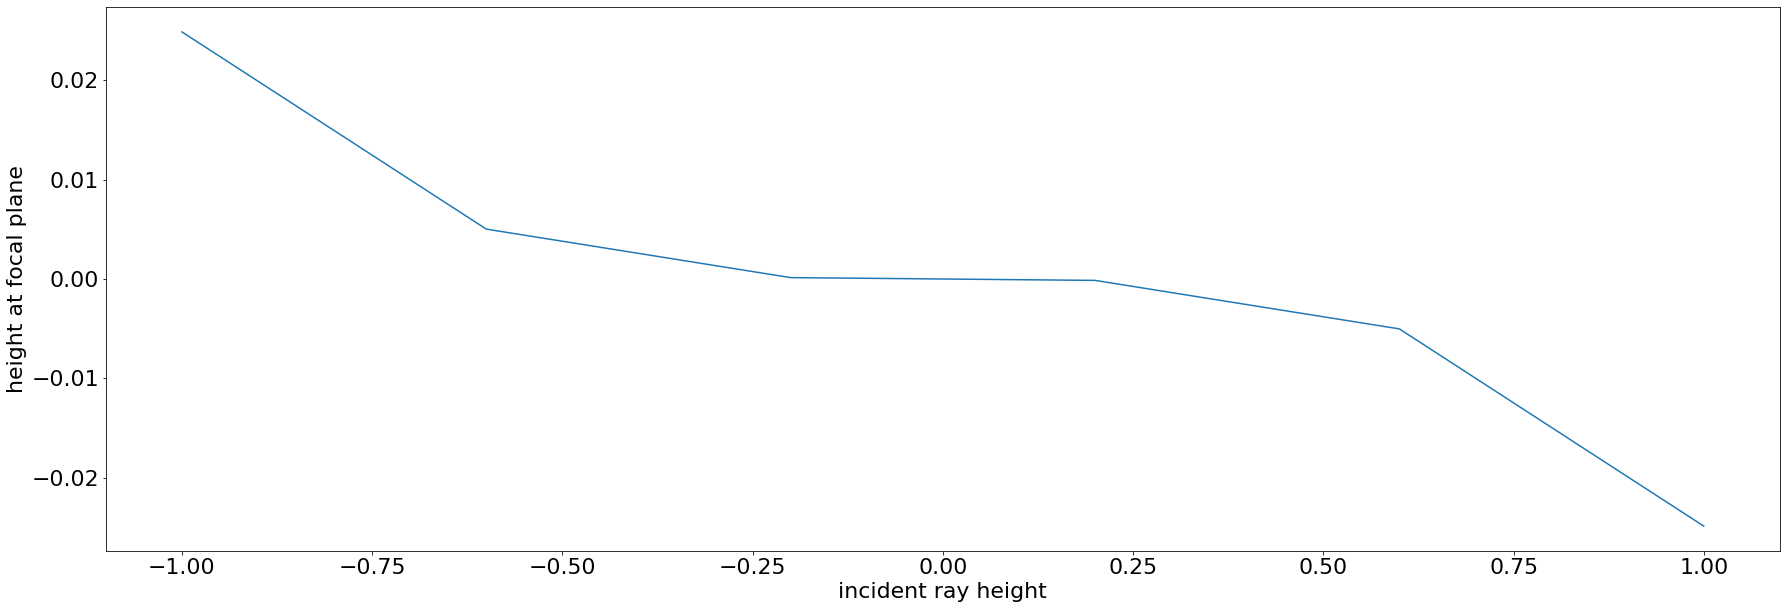

In [ ]:
plt.plot(rP[0:6,0,1],rP[0:6,3,1])
plt.xlabel("incident ray height")
plt.ylabel("height at focal plane")

In [ ]:
180*.3/np.pi

17.188733853924695